In [1]:
import tensorflow as tf
import numpy as np
from train import create_dataset
from utils.metrics import F1Score, PositiveRate, PredictedPositives
from config import project_config as config
import os
from matplotlib import pyplot as plt
from tf_keras_vis.scorecam import Scorecam
from skimage.measure import block_reduce

In [2]:
model_name = 'best_on_all'
# saved_model_path = f'Model Repo/{model_name}'
saved_model_path = 'training_output/savedmodels/fn_best_on_all_4_features_noisytemp'
datapath = 'data/Tensorflow/window_21/labelled'
pred_output_path = f'Results/Predictions/{model_name}'

os.makedirs(pred_output_path, exist_ok=True)
# assert len(os.listdir(pred_output_path)) == 0, f"Output directory is not empty."  # Prevents overwriting

model = tf.keras.models.load_model(
    saved_model_path,
    custom_objects={  # These are needed to load the model. We're not calculating them here
        'F1Score': F1Score(name='F1Score'),
        'PositiveRate': PositiveRate(name='PositiveRate'),
        'PredictedPositives': PredictedPositives(name='PredictedPositives')
    }
)

In [3]:
def score_function(output): # output shape is (batch_size, 1)
   return output[:, 0]

def model_modifier_function(cloned_model):
   cloned_model.layers[-1].activation = tf.keras.activations.linear

1/1 [==============================] - 0s 10ms/step


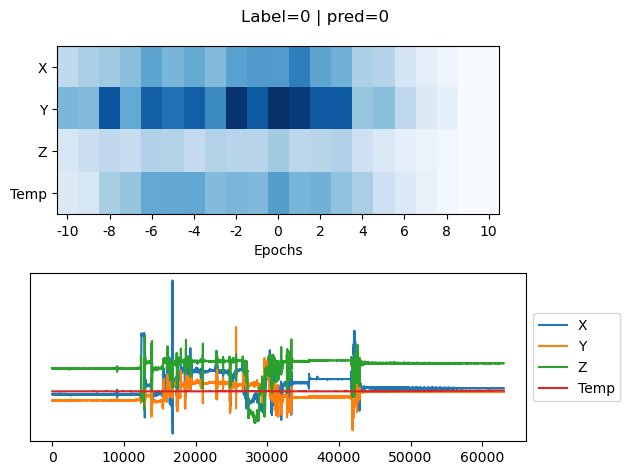

In [ ]:
from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore

replace2linear = ReplaceToLinear()

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

subject_id = 21

test_dataset = create_dataset(
    f"{datapath}/sub_{subject_id:03d}*",
    compressed=False,  # Unlabelled data is saved with GZIP compression
    has_labels=True,
    repeat=False,
    batch_size=1,
    # filters=[lambda x, y: x['central_epoch_ts'] == b'2021-07-21 02:00:00']
)

score = BinaryScore(1.0)

plot_path = 'Results/Saliency Plots'
os.makedirs(plot_path, exist_ok=True)

for x, y in test_dataset:
    # features = x['features']

    if not (np.random.random() <= 0.1):
        continue
    
    label = int(y.numpy()[0])
    timestamp = x['central_epoch_ts'].numpy()[0].decode('utf-8')

    colored_features = tf.repeat(tf.expand_dims(x['features'], -1), repeats=3, axis=-1)
    
    # Generate saliency map
    saliency_map = saliency(
        score,
        colored_features,
        smooth_samples=20, # The number of calculating gradients iterations.
        smooth_noise=20
    )

    # print(saliency_map.shape)
    # print(cam[0].shape)
    # f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

    # heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    # ax[0].imshow(x)
    # ax[0].imshow(heatmap, cmap='jet', alpha=0.5)
    # ax[0].axis('off')

    # plt.tight_layout()
    # plt.show()

    saliency_map = saliency_map[0, :, :]
    
    temp = block_reduce(saliency_map, block_size=(3000, 1), func=np.mean)

    # fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plt.subplot(2, 1, 1)
    sal_img = np.repeat(temp, repeats=2, axis=1)

    # temperature = sal_img[:, [-1]]
    # xyz = np.sum(sal_img[:, :-1], axis=1, keepdims=True)
    # sal_img = np.concatenate([temperature, xyz], axis=1)
    
    feature_names = ['X', 'Y', 'Z', 'Temp']
    
    plt.imshow(sal_img.transpose(), cmap='Blues')
    plt.xlabel('Epochs')
    plt.yticks([2*k+0.5 for k in range(4)], feature_names)
    plt.xticks([2*k for k in range(11)], [2*k-10 for k in range(11)])
    # plt.ylabel('Features')
    # plt.show()
    
    plt.subplot(2, 1, 2)
    for i in range(4):
        # feat = x['features'][0, (k*3000):((k+1)*3000), i] - np.mean(x['features'][0, :, i])
        # feat = block_reduce(x['features'][0, :, i].numpy(), block_size=(3000), func=np.mean)
        feat = x['features'][0, :, i].numpy()
        plt.plot(feat, label=feature_names[i])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.yticks([])

    pred = model.predict(tf.expand_dims(x['features'], -1))
    plt.suptitle(f"Label={label} | pred={round(pred[0][0])}")

    plt.tight_layout()
    plt.show()
    
    # plt.savefig(f"{plot_path}/sal_{timestamp}_label_{label}")
    break